# MetSIM Model Fitting
## 1. Setup
## 2. Methylation Import
## 3. Phenotype Data Import and Normalization
## 4. Feature Selection
## 5. Matrix Decomposition
## 6. CV Regression Model
## 7. Data Export for GREAT Annotation
## 8. Figures 

## 1. Setup

In [1]:
# Set directory path and to data cleaning tools

working_directory = '../pwd'
base_path = '../pwd'

In [2]:
# Library import
import numpy as np
import seaborn as sns
import pandas as pd
import random
import scipy

In [3]:
# import normalization code and kNN code
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append(ewas_tools)
from data_cleanup import *
#from kNNimputer import *

## 2. Import methylation data frame

In [4]:
# import methylation data
meth_df = pd.read_csv(base_path + 'Metsim_EWAS/MetsimData/METSIM_adipose_methylation_imputed.txt', sep='\t', header=0, index_col=0, na_values='')

In [5]:
# retrieve list of samples
meth_df_sample_names = list(meth_df)

## 3. Whole Cohort Phenotype Data Normalization

In [6]:
# import dataframe and initialize DataCleanup class
whole_cohort_phenotype_data = DataCleanup(working_directory + 'full_cohort_data/METSIM-Baseline-FollowUp-imputed_values.txt', separator='\t')
# transpose phenotype data
whole_cohort_phenotype_data.df = whole_cohort_phenotype_data.df.transpose()
print(len(list(whole_cohort_phenotype_data.df)))

/Users/colinfarrell/Documents/PythonScripts/LMM_EWAS/data_cleanup.py:22: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  imported_data_frame = pd.DataFrame.from_csv(file, sep=separator, header=0, index_col=0)


243


Discard Phenotype Categories that are Directly Indivative of Type2 Diabetes Status

In [7]:
# remove samples with type1 diabetes
whole_cohort_type1 = whole_cohort_phenotype_data.df.loc[whole_cohort_phenotype_data.df['dmtype'] == 1]
type1_list = whole_cohort_type1.index
print(len(type1_list))
whole_cohort_phenotype_data.list_row_removal(type1_list)

25


In [8]:
# Remove feature information colinear with T2D
diabetes_columns_to_remove = ['fmdm',	'dm',	'dmy',	'dmspouse',	'dmtype',	'famdm',	'EUDG',	'allSmpls',	
                              'betabloc',	'nitrate',	'diuretic',	'cachbloc',	'AngRBloc',	'ACEInhib',	'ASA',	
                              'sulfurea',	'metformi',	'insulin',	'glitatso',	'statin',	'statinType',	'fibrate',	
                              'deprmed',	'medcount',	'GLTOL5_6',	'GLTOL6_1',	'DM_AGE',	'DM_YEARS',	'F_dminstreatment',	
                              'F_dminstreatmentdelay',	'F_dm',	'F_dmy',	'F_famdmgrandparents',	'F_famdmfamily',	'F_famdmmother',	
                              'F_famdmfather',	'F_famdmsister',	'F_famdmbrother',	'F_allSmpls',	'F_betabloc',	'F_nitrate',	
                              'F_diuretic',	'F_cachbloc',	'F_AngRBloc',	'F_ACEInhib',	'F_ASA',	'F_sulfurea',	'F_metformi',	
                              'F_insulin',	'F_glitatso',	'F_statin',	'Reimb_DM_date',	'F_Incident_T2DM_2013',	'F_FollowUpTime_T2DM_2013',
                              'F_Incident_T2DM_092014',	'F_FollowUpTime_T2DM_092014',	'TotalT2DM_2013',	'TotalT2DM_092014',	'F_GLTOL5_6',
                              'F_GLTOL6_1',	'F_GLTOL5_6_HbA1c',	'F_DM_AGE',	'F_DM_YEARS',	'D0_dm',	'D0_DMType',	'D0_GLTOL5_6_HbA1c',
                              'D18_DMTYPE', 'FINRISKI', 'QUICKI', 'HOMAIR', 'FINRISKI_CLASSES', 'F_fmdm']

# Categories removed during imputation
categories_removed_in_imputation  = ['dmy', 'statinType', 'DM_AGE', 'DM_YEARS', 'F_dminstreatment',
 'F_dminstreatmentdelay', 'F_dmy', 'Reimb_DM_date', 'F_DM_AGE', 'F_DM_YEARS',
 'D0_dm', 'D0_DMType', 'D0_GLTOL5_6_HbA1c', 'D18_DMTYPE']

for category in categories_removed_in_imputation:
    diabetes_columns_to_remove.remove(category)

print(len(list(whole_cohort_phenotype_data.df)))
whole_cohort_phenotype_data.list_column_removal(diabetes_columns_to_remove)
print(len(diabetes_columns_to_remove))
print(len(list(whole_cohort_phenotype_data.df)))

243
58
185


In [9]:
# transform the dataframe to
whole_cohort_phenotype_data.numeric_data_transformation(errors='coerce')

In [10]:
# remove rows with a lot of missing information
print(len(whole_cohort_phenotype_data.df.index))
#whole_cohort_phenotype_data.remove_low_information_rows(missing_value_tolerance=.25)
print(len(whole_cohort_phenotype_data.df.index))
#low_information_list = whole_cohort_phenotype_data.dropped_row_index

10172
10172


In [11]:
# remove columns with high proportion of missing information
print(len(list(whole_cohort_phenotype_data.df)))
whole_cohort_phenotype_data.remove_low_information_columns(missing_value_tolerance=0.7)
print(len(list(whole_cohort_phenotype_data.df)))

185
185


In [12]:
# missing data imputation
whole_cohort_phenotype_data.standard_imputation(imputation_strategy='median')
whole_cohort_phenotype_data.normal_transformation(normal_test=1000, normal_percentile=0.01)
whole_cohort_phenotype_data.remove_low_variance_features()
print(len(list(whole_cohort_phenotype_data.df)))

184


In [13]:
# for categorical variable I need an unaltered version of the dataframe
whole_cohort_phenotype_data_unaltered = DataCleanup(working_directory + 'full_cohort_data/METSIM-Baseline-FollowUp-D0-D18_2016-03-15.dat.txt', separator='\t')
# drop row data not carried
whole_cohort_phenotype_data_unaltered.list_row_removal([int(x) for x in type1_list])

/Users/colinfarrell/Documents/PythonScripts/LMM_EWAS/data_cleanup.py:22: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  imported_data_frame = pd.DataFrame.from_csv(file, sep=separator, header=0, index_col=0)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (19,20,21,22,23,35,36,37,38,39,40,41,44,45,46,47,48,49,50,51,52,53,62,63,64,65,66,67,71,74,77,87,88,89,90,112,113,144,145,146,147,148,156,157,160,161,162,167,168,172) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
# get type2 diabetes label
whole_cohort_diabetes = whole_cohort_phenotype_data_unaltered.df['dmtype']
whole_cohort_diabetes = whole_cohort_diabetes.replace('Healthy', 0)
whole_cohort_diabetes = whole_cohort_diabetes.replace('Type 2 diabetes', 1)

## Feature Selection

In [15]:
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Feature Selection to Maximize distance between healthy and type2 labels

In [16]:
# initialize random logistic regression model for feature selection
# Set extremely lax selection crieteria 
whole_random_log_reg = RandomizedLogisticRegression(sample_fraction=0.75, n_resampling=1000, selection_threshold=.1, scaling=0.5, C=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLogisticRegression is deprecated; The class RandomizedLogisticRegression is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


In [17]:
whole_training_data = np.asarray(whole_cohort_phenotype_data.df.values)
whole_target = np.asarray(whole_cohort_diabetes.values)

In [18]:
whole_random_log_reg_fit = whole_random_log_reg.fit(whole_training_data, whole_target)
whole_selected_index = whole_random_log_reg_fit.get_support()
whole_selected_index = np.ndarray.tolist(whole_selected_index)

In [19]:
whole_selected_features_welch = []
whole_column_list = list(whole_cohort_phenotype_data.df)

for site in zip(whole_selected_index, whole_column_list):
    if site[0] == True:
        whole_selected_features_welch.append(site[1])

In [20]:
# remove any follow-up features that  may  have been selected

follow_up_feature_removal = ['fmhypert']

for category in whole_selected_features_welch:
    if 'F_' in category:
        follow_up_feature_removal.append(category) 
        
for category in follow_up_feature_removal:
    whole_selected_features_welch.remove(category)

print(whole_selected_features_welch)

['coffee', 'elevgl', 'XC', 'mmass', 'S_totalc', 'S_ldlc', 'P_gl0', 'P_gl120', 'P_ins0', 'P_proi0', 'P_ffa30', 'P_ffa120', 'UAlb', 'UAlbTh0', 'UAlbTh1', 'UAlbV', 'B_GHbA1C', 'WHR', 'glauc', 'gliauc', 'ffaauc', 'UAE']


In [21]:
def welch_ttest(pandas_column1=None, pandas_column2=None):
    pandas_column1_var = pandas_column1.var()
    pandas_column1_mean = pandas_column1.mean()
    pandas_column1_sample_size = pandas_column1.count()
    pandas_column2_var = pandas_column2.var()
    pandas_column2_mean = pandas_column2.mean()
    pandas_column2_sample_size = pandas_column2.count()
    top = pandas_column1_mean - pandas_column2_mean
    bottom = np.sqrt((pandas_column1_var / pandas_column1_sample_size) + (pandas_column2_var / pandas_column2_sample_size))
    test_statistic = abs(top/bottom)
    return test_statistic

In [22]:
# see which features do the best job seperating type2 and healthy

welch_scores = []

for feature in whole_selected_features_welch:
    # reindex pca_values dataframe so merge works correctly
    phenotype_information = pd.DataFrame(whole_cohort_phenotype_data.df[feature])
    phenotype_information = phenotype_information.set_index(whole_cohort_phenotype_data_unaltered.df.index)
    phenotype_information['dmtype'] = whole_cohort_diabetes
    healthy = phenotype_information.loc[phenotype_information['dmtype'] == 0]
    type2_baseline = phenotype_information.loc[phenotype_information['dmtype'] == 2]
    # maximize the test statistic from a Welch's t-test 
    welch_scores.append(welch_ttest(healthy[feature], type2_baseline[feature]))
    

In [23]:
sorted_features = [x for _,x in sorted(zip(welch_scores,whole_selected_features_welch))][::-1]

In [24]:
# start with feature with highest welch statistic, and then add and see if score increases
starting_feature = sorted_features[0]
starting_score = max(welch_scores)
sorting_list = sorted_features[1:]
feature_to_add = None


welch_feature_list_1max = [starting_feature]

better_seperation = True

while better_seperation:
    
    better_seperation = False
    
    for feature in sorting_list:
        features_to_test = welch_feature_list_1max + [feature]
        whole_dimensionality_reduction_array = whole_cohort_phenotype_data.df[features_to_test].values
        whole_pca = PCA(n_components=len(features_to_test), whiten=False, )
        # Fit PCA object
        whole_pca.fit(whole_dimensionality_reduction_array)
        # Return a matrix with matrix decomposition values
        whole_pca_values = whole_pca.transform(whole_dimensionality_reduction_array)
        whole_pca_values_df = pd.DataFrame(whole_pca_values)
        # reindex pca_values dataframe so merge works correctly
        whole_pca_values_df = whole_pca_values_df.set_index(whole_cohort_phenotype_data_unaltered.df.index)
        whole_pca_values_df['dmtype'] = whole_cohort_diabetes
        healthy = whole_pca_values_df.loc[whole_pca_values_df['dmtype'] == 0]
        type2_baseline = whole_pca_values_df.loc[whole_pca_values_df['dmtype'] == 2]
        # maximize the test statistic from a Welch's t-test
        test_statistic = welch_ttest(healthy[0], type2_baseline[0])
        if test_statistic >= starting_score:
            print(test_statistic)
            better_seperation = True
            starting_score = test_statistic
            feature_to_add = feature
            
    if better_seperation:
        welch_feature_list_1max.append(feature_to_add)
        sorting_list.remove(feature_to_add)
    
print(welch_feature_list_1max)

60.2533732537
64.8998518401
65.6601724907
74.6631294797
77.2964636124
77.6079569087
79.9400062185
82.7117237717
82.8708879166
82.956978796
['P_gl0', 'P_gl120', 'elevgl', 'S_ldlc', 'UAlbTh1', 'UAlbTh0']


## 5. Matrix Decomposition

In [25]:
# Selected feature subset array
whole_dimensionality_reduction_array_welch_1max = whole_cohort_phenotype_data.df[welch_feature_list_1max].values

In [26]:
# Initialize SVD-PCA object
whole_pca_welch_1max = PCA(n_components=len(welch_feature_list_1max), whiten=False, )
# Fit PCA object
whole_pca_welch_1max.fit(whole_dimensionality_reduction_array_welch_1max)
# Return a matrix with matrix decomposition values
whole_pca_values_welch_1max = whole_pca_welch_1max.transform(whole_dimensionality_reduction_array_welch_1max)
whole_pca_values_welch_1max_df = pd.DataFrame(whole_pca_values_welch_1max)
# reindex pca_values dataframe so merge works correctly
whole_pca_values_welch_1max_df = whole_pca_values_welch_1max_df.set_index(whole_cohort_phenotype_data_unaltered.df.index)
print(whole_pca_welch_1max.explained_variance_ratio_)
print(whole_pca_welch_1max.get_params())

[ 0.29322219  0.21735838  0.19285445  0.13779059  0.09953741  0.05923697]
{'copy': True, 'iterated_power': 'auto', 'n_components': 6, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}


In [27]:
# contribution of each feature to PCs
I = np.identity(whole_dimensionality_reduction_array_welch_1max.shape[1]) 
whole_coefs_welch_1max = whole_pca_welch_1max.transform(I)
whole_coefs_welch_1max = pd.DataFrame(whole_coefs_welch_1max)
whole_coefs_welch_1max.columns = welch_feature_list_1max

In [28]:
# table output, first four principal components
import openpyxl
row_labels = ['PC 1', 'PC 2', 'PC 3', 'PC 4']
column_labels = ['Glucose Baseline', 'Glucose 120min', 'Elevated Blood Glucose', 'LDL',  'Urine Albumin Baseline', 'Urine Albumin 60min', 'Variance Explained']

table_df = whole_coefs_welch_1max.copy()

table_df['Variance Explained'] = whole_pca_welch_1max.explained_variance_ratio_
table_df = table_df.loc[0:3]
table_df.index = row_labels
table_df.columns = column_labels

#writer = pd.ExcelWriter(working_directory + 'PC_table.xlsx')

#table_df.to_excel(writer,'Sheet1')

#writer.save()
print(table_df)

      Glucose Baseline  Glucose 120min  Elevated Blood Glucose       LDL  \
PC 1          0.666276        0.032213                0.175457 -0.462106   
PC 2          0.608322        0.195213                0.153193  0.643753   
PC 3          0.274149       -0.028083               -0.060480 -0.148220   
PC 4         -0.236959        0.318879                0.900996 -0.130548   

      Urine Albumin Baseline  Urine Albumin 60min  Variance Explained  
PC 1                0.416932            -0.371285            0.293222  
PC 2               -0.389891            -0.061948            0.217358  
PC 3                0.114749             0.892478            0.192854  
PC 4               -0.090244             0.085250            0.137791  


In [29]:
# def function to give r^2
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [30]:
# set style for plots and patches
red_patch = mpatches.Patch(color=sns.color_palette("Reds")[-2], label='Type 2 Follow-up')
blue_patch = mpatches.Patch(sns.color_palette("Blues")[-2], label='Type 2 Baseline')
green_patch = mpatches.Patch(color=sns.color_palette("Greens")[-2], label='Healthy')
sns.set(style="darkgrid")

In [31]:
welch_comparison_1max_df = pd.concat([whole_pca_values_welch_1max_df,whole_cohort_phenotype_data_unaltered.df], axis=1)
welch_comparison_1max_df.rename(columns={0: 'PC1', 1: 'PC2', 2: 'PC3', 3: 'PC4'}, inplace=True)

In [32]:
# filter samples without followup information 
welch_comparison_followup_1max = welch_comparison_1max_df[welch_comparison_1max_df['F_Res_day'] != ' ']

# get label for people who develop type 2 diabetes at follow-up   F_dmy
# df['color'] = ['red' if x == 'Z' else 'green' for x in df['Set']]

# set folloup diabetes or healthy labels
conditions = [(welch_comparison_followup_1max['dmtype'] == 0) & (welch_comparison_followup_1max['F_dmy'] == ' '), (welch_comparison_followup_1max['dmtype'] == 0) & (welch_comparison_followup_1max['F_dmy'] != ' '), (welch_comparison_followup_1max['dmtype'] == 2)]
choices = ['Healthy', 'Type 2 Follow-up', 'Type 2 Baseline']
welch_comparison_followup_1max['DiabetesClassifier'] = np.select(conditions, choices)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [33]:
healthy = welch_comparison_followup_1max.loc[welch_comparison_followup_1max['DiabetesClassifier'] == 'Healthy']
type2_baseline = welch_comparison_followup_1max.loc[welch_comparison_followup_1max['DiabetesClassifier'] == 'Type 2 Baseline']
type2_followup = welch_comparison_followup_1max.loc[welch_comparison_followup_1max['DiabetesClassifier'] == 'Type 2 Follow-up']


## 6. Data Prep for Linear Models

In [34]:
# retrieve sample information
pc1_values = list(whole_pca_values_welch_1max_df.loc[[int(x) for x in meth_df_sample_names], 0])
pc2_values = list(whole_pca_values_welch_1max_df.loc[[int(x) for x in meth_df_sample_names], 1])

## Select relevant methylation sites

Utilize randomized lasso to select relevant methylation sites

In [35]:
# imports
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [36]:
# drop all rows with np.nan (this is not the best way to normalize the data, consider imputing with k-means nearest neighbor)
methylation_model_values = meth_df[meth_df.notnull().all(1)].values

In [37]:
meth_model_df = meth_df[meth_df.notnull().all(1)]

In [38]:
# setting lasso sites, so I don't have to run a computationally expensive command everytime, also the results are stable but there are some minor 
# difference do to the random scaling
randomized_lasso_sites = ['1:1871979', '1:2447909', '1:2534375', '1:2798205', '1:3487922', '1:3615428', '1:4008051', '1:4065273', '1:4425712', '1:5786866', '1:5937168', '1:6143147', '1:6658770', '1:6681744', '1:6694980', '1:8223589', '1:8224618', '1:8224662', '1:9008923', '1:9024552', '1:10009115', '1:10478726', '1:10640438', '1:10828178', '1:12009955', '1:12639019', '1:13934493', '1:15004727', '1:15445060', '1:15809602', '1:16146114', '1:16146247', '1:16352491', '1:16356500', '1:16356583', '1:16419218', '1:16865801', '1:17399784', '1:17784583', '1:20251222', '1:21001668', '1:22328280', '1:22875629', '1:26180432', '1:26235817', '1:28424201', '1:28693732', '1:28880539', '1:28880567', '1:33226521', '1:33775350', '1:36905876', '1:39621552', '1:39940224', '1:42814984', '1:45231449', '1:45450639', '1:48701895', '1:52424121', '1:54271604', '1:54884038', '1:58916198', '1:64650628', '1:64680774', '1:69558140', '1:71511514', '1:82196206', '1:86184066', '1:86392911', '1:89739007', '1:92135620', '1:94032577', '1:96712340', '1:104950195', '1:145390306', '1:150050771', '1:150194485', '1:150194575', '1:150194616', '1:152276149', '1:156255456', '1:156293491', '1:156432547', '1:157833691', '1:159188173', '1:159419661', '1:159714724', '1:162977425', '1:168299056', '1:169832344', '1:172717486', '1:175702451', '1:180156668', '1:180914966', '1:180936458', '1:185219992', '1:194326968', '1:200863772', '1:200885246', '1:201532405', '1:202039261', '1:208913348', '1:219447463', '1:221674812', '1:222704638', '1:223253577', '1:224667103', '1:226230015', '1:228206935', '1:231250528', '1:236811527', '1:237194100', '1:237382690', '1:241350117', '1:242174316', '1:243649330', '1:243837048', '1:248059424', '2:1604810', '2:2633509', '2:2898048', '2:3679123', '2:6947548', '2:7427651', '2:10733543', '2:10949202', '2:11298840', '2:12046934', '2:16013712', '2:23912712', '2:25046859', '2:25638408', '2:26440942', '2:26509616', '2:26761219', '2:27022469', '2:27605983', '2:30822054', '2:33600856', '2:36319526', '2:37408585', '2:39383919', '2:42930812', '2:43059433', '2:43231620', '2:43411821', '2:51377738', '2:52159274', '2:55869569', '2:61003140', '2:62078301', '2:64134529', '2:64292764', '2:64297165', '2:72235444', '2:76366272', '2:79515219', '2:85499641', '2:91704042', '2:95541843', '2:96815492', '2:97228039', '2:98534531', '2:99159792', '2:99193496', '2:100871330', '2:102581225', '2:103373039', '2:111955485', '2:112593186', '2:112899508', '2:113254639', '2:113338563', '2:113479613', '2:119937935', '2:120222697', '2:121379348', '2:124310906', '2:126034805', '2:127548600', '2:128199593', '2:128340902', '2:129207497', '2:130937932', '2:132275578', '2:132345267', '2:132533847', '2:132589749', '2:134347925', '2:134435665', '2:139211379', '2:144419427', '2:151811868', '2:158371984', '2:159784385', '2:161340962', '2:167216600', '2:172630974', '2:178331205', '2:180565598', '2:186106511', '2:186729478', '2:188844911', '2:209031975', '2:209032161', '2:212597573', '2:216085026', '2:216110597', '2:216198536', '2:217270861', '2:219482017', '2:220372091', '2:224281125', '2:225394813', '2:227872182', '2:230948999', '2:232493463', '2:232736672', '2:233329064', '2:235953159', '2:236203910', '2:236613478', '2:236724861', '2:237250798', '2:238621790', '2:239705322', '2:240088108', '2:240691581', '2:242149072', '2:242436238', '2:242851403', '2:242917306', '3:4480983', '3:5104609', '3:5335902', '3:8798587', '3:10148483', '3:10377651', '3:13528298', '3:32403689', '3:32888850', '3:37012098', '3:37741818', '3:41096756', '3:42568440', '3:44612896', '3:49085726', '3:49174005', '3:51960778', '3:53425148', '3:53534200', '3:56543749', '3:56618481', '3:59497817', '3:62684806', '3:71262744', '3:71362457', '3:71381410', '3:71661862', '3:71663533', '3:72779159', '3:72781355', '3:72889276', '3:77427967', '3:77725079', '3:88643167', '3:101393296', '3:104406940', '3:109038578', '3:111903461', '3:112506802', '3:112925248', '3:119878445', '3:122248710', '3:124633544', '3:127195947', '3:128700025', '3:132022027', '3:137142212', '3:140894678', '3:141190538', '3:141910162', '3:148305773', '3:148862043', '3:148865787', '3:149286769', '3:150238322', '3:152707515', '3:154917412', '3:155939338', '3:157356944', '3:165975637', '3:170477076', '3:170693350', '3:171415283', '3:171544699', '3:173030774', '3:174126380', '3:182669780', '3:183938856', '3:183984653', '3:185704237', '3:186437300', '3:187024190', '3:189483325', '3:189641784', '3:191661609', '3:193609171', '3:194596923', '3:195327012', '3:195395398', '3:195498270', '3:195926552', '3:196403413', '3:197306028', '4:982852', '4:1010783', '4:1277102', '4:1278892', '4:1316895', '4:1320119', '4:1354211', '4:1354350', '4:1524662', '4:1599448', '4:3439604', '4:3503467', '4:3862072', '4:3921935', '4:6425151', '4:7279696', '4:7361885', '4:8278124', '4:8288521', '4:8335738', '4:8746298', '4:8756750', '4:8769769', '4:11880396', '4:16011211', '4:16011212', '4:18674031', '4:27033741', '4:37136467', '4:37977149', '4:40036165', '4:40399231', '4:42041628', '4:49163166', '4:56927413', '4:57701392', '4:57701401', '4:62512726', '4:63254338', '4:76484536', '4:76658216', '4:76970995', '4:77414989', '4:89669233', '4:95177616', '4:97998368', '4:104618873', '4:109933639', '4:113610800', '4:113752105', '4:118429003', '4:119424852', '4:122165680', '4:122983417', '4:125877331', '4:129751458', '4:129751492', '4:132651089', '4:132685363', '4:139405456', '4:139855027', '4:140458111', '4:140682401', '4:144337515', '4:153167913', '4:153896359', '4:153922741', '4:155038983', '4:165854509', '4:174554553', '4:174990168', '4:178539205', '4:181322264', '4:183733831', '4:183742037', '4:183742145', '4:184327742', '4:184564198', '4:185037249', '4:185174132', '4:185254952', '4:185750224', '4:186522954', '4:186851612', '4:186874342', '4:187969167', '4:187969235', '4:189005625', '4:189023872', '4:190989026', '5:462995', '5:478580', '5:478599', '5:685111', '5:1207526', '5:1331693', '5:1834277', '5:1939170', '5:1964423', '5:2261278', '5:3218303', '5:3399124', '5:3489595', '5:3751054', '5:6604788', '5:13754796', '5:19270875', '5:19359617', '5:19573548', '5:22116021', '5:27637908', '5:28926809', '5:30404834', '5:31606520', '5:32587995', '5:35892037', '5:37657410', '5:39707018', '5:42798065', '5:53155462', '5:57625981', '5:62510356', '5:64894406', '5:64894449', '5:67113834', '5:67423332', '5:68591955', '5:68600339', '5:71667161', '5:78876719', '5:79354648', '5:79354703', '5:88398656', '5:94965600', '5:96154878', '5:100623334', '5:101491942', '5:102559429', '5:105027744', '5:119026149', '5:119185299', '5:122093921', '5:123956141', '5:125259951', '5:125332424', '5:125873804', '5:127088546', '5:135082127', '5:137379378', '5:138078841', '5:138228661', '5:140014663', '5:150946773', '5:154011103', '5:154965431', '5:156367300', '5:157531293', '5:159612364', '5:164488914', '5:172725870', '5:173390694', '5:173661614', '5:174410847', '5:174488956', '5:176143265', '5:176143314', '5:177921624', '5:177963204', '5:178169909', '5:178383953', '5:178478758', '5:178564500', '5:179484839', '6:2000549', '6:4970788', '6:6031519', '6:7706913', '6:7917075', '6:10307056', '6:15761015', '6:16267476', '6:17272740', '6:18273644', '6:18397131', '6:18544872', '6:21776570', '6:21817071', '6:27544965', '6:27544977', '6:28622483', '6:29648468', '6:29648565', '6:29649092', '6:30831195', '6:30935226', '6:31052447', '6:32441870', '6:33464783', '6:33947901', '6:37723353', '6:39146129', '6:41061430', '6:41817494', '6:42775168', '6:43101271', '6:47621846', '6:50270839', '6:53598357', '6:55005928', '6:67390250', '6:67986905', '6:69832027', '6:75508785', '6:76160101', '6:81816363', '6:87312910', '6:97298877', '6:98864535', '6:106383889', '6:107333002', '6:107378685', '6:108099313', '6:114161505', '6:117259581', '6:121781896', '6:122006953', '6:132146064', '6:133601825', '6:133771248', '6:134539726', '6:134627285', '6:136092496', '6:143312217', '6:143497644', '6:149846962', '6:150108750', '6:151085416', '6:154178345', '6:155234648', '6:159167642', '6:160153592', '6:167592986', '6:167597532', '6:168386636', '6:170475254', '6:170574989', '7:813650', '7:884057', '7:896142', '7:1328721', '7:1482135', '7:1532471', '7:1533963', '7:1574812', '7:1889521', '7:1892530', '7:2754084', '7:2935067', '7:2950244', '7:3230059', '7:4275677', '7:4308986', '7:5175314', '7:5292446', '7:5592705', '7:5874602', '7:6079952', '7:6094701', '7:6115546', '7:10929621', '7:18927782', '7:23944059', '7:25074850', '7:30824170', '7:35420895', '7:36552656', '7:37463049', '7:37987631', '7:38741104', '7:38741194', '7:38853989', '7:43361501', '7:43923162', '7:45553843', '7:45850537', '7:45852705', '7:47705323', '7:48494053', '7:49568481', '7:62986705', '7:63033332', '7:63233536', '7:66368105', '7:66822268', '7:71337739', '7:71990127', '7:73818405', '7:77301546', '7:77315621', '7:77941234', '7:81530801', '7:98336448', '7:101243670', '7:107243559', '7:115526385', '7:118204516', '7:127799143', '7:128521073', '7:129794579', '7:133995457', '7:139699153', '7:140185552', '7:140210808', '7:145123661', '7:148931522', '7:150512380', '7:151393354', '7:152197814', '7:152269027', '7:153484281', '7:155341811', '7:155640085', '7:156010297', '7:156692859', '7:157139792', '7:157946907', '7:158045641', '7:158072539', '7:158217483', '7:158798622', '8:694696', '8:697380', '8:1365110', '8:1365175', '8:1365186', '8:1365201', '8:1783534', '8:1807295', '8:2547116', '8:2736314', '8:3007946', '8:3097684', '8:4311499', '8:4584684', '8:4607605', '8:7877752', '8:8094725', '8:8259306', '8:8730487', '8:9294277', '8:10987966', '8:11882913', '8:12897602', '8:13472636', '8:14398717', '8:17770035', '8:18420055', '8:19464482', '8:22206763', '8:22471823', '8:27886904', '8:38451865', '8:46864066', '8:46936299', '8:49784646', '8:55952796', '8:56364087', '8:56602266', '8:56736653', '8:60674051', '8:64012225', '8:70875601', '8:83353847', '8:83797037', '8:89399201', '8:90444776', '8:97903606', '8:101766149', '8:112098292', '8:118778723', '8:121014669', '8:123949931', '8:123950010', '8:126778969', '8:127811580', '8:135471497', '8:138246669', '8:139004714', '8:139118761', '8:140559721', '8:140574127', '8:140930849', '8:140968751', '8:141583354', '8:141629833', '8:142039767', '8:143142634', '8:143234609', '8:144218381', '8:144267153', '8:144321944', '8:144523018', '8:145681712', '8:146068322', '9:209326', '9:502740', '9:736019', '9:2717923', '9:5131732', '9:5487781', '9:5817338', '9:9140665', '9:16787671', '9:21214678', '9:24580383', '9:28150111', '9:33132491', '9:33750238', '9:34054827', '9:34726523', '9:37489863', '9:42204111', '9:71477605', '9:73038936', '9:73040200', '9:74640370', '9:74983908', '9:75115003', '9:78820927', '9:79570352', '9:83893489', '9:84330090', '9:91623709', '9:92050630', '9:92239232', '9:93903636', '9:94516768', '9:97022625', '9:98847911', '9:104481467', '9:105004836', '9:111638429', '9:111639231', '9:115069665', '9:117187568', '9:117846080', '9:124570006', '9:127319560', '9:127744678', '9:128778169', '9:128786893', '9:128882137', '9:132191851', '9:132414447', '9:134442560', '9:135183254', '9:135195790', '9:135354006', '9:136536632', '9:136536679', '9:136883022', '9:137156006', '9:137308242', '9:137486067', '9:138005261', '9:138387482', '9:139251481', '9:139287674', '9:139470166', '9:139934907', '9:139985159', '9:139987350', '9:140076358', '9:140080582', '9:140120396', '9:140142300', '9:140653361', '9:140742662', '10:1260466', '10:5683650', '10:5914811', '10:6781434', '10:7842558', '10:7903149', '10:8328679', '10:8910683', '10:9099456', '10:11907860', '10:12316764', '10:12316858', '10:13377717', '10:13599621', '10:14035043', '10:14728153', '10:16480600', '10:16505605', '10:17239948', '10:21108247', '10:21183609', '10:21337795', '10:24658925', '10:28611968', '10:28692622', '10:31248433', '10:32257014', '10:32301260', '10:35405036', '10:36920694', '10:37108908', '10:44853014', '10:45928822', '10:51518910', '10:51535801', '10:51546335', '10:51624621', '10:51834537', '10:61103960', '10:64376478', '10:65501698', '10:70277941', '10:70832046', '10:72665106', '10:83958668', '10:84639403', '10:85829369', '10:88342728', '10:90989278', '10:95054389', '10:98132017', '10:105231640', '10:105584757', '10:115542289', '10:117978304', '10:118442428', '10:121734119', '10:122687143', '10:126157475', '10:126181712', '10:126840273', '10:131323100', '10:131920161', '10:132099313', '10:132099314', '10:132099327', '10:132099372', '10:132329859', '10:132448749', '10:134016114', '11:235166', '11:698808', '11:1159133', '11:1218709', '11:1318898', '11:1516692', '11:1857270', '11:1985287', '11:2021626', '11:2767189', '11:3513098', '11:5177789', '11:5675013', '11:8264560', '11:9134578', '11:9412675', '11:11575562', '11:17784707', '11:22043190', '11:26188986', '11:33453510', '11:36823646', '11:41086727', '11:43962153', '11:44023871', '11:55677562', '11:60218503', '11:60858030', '11:61675751', '11:63335890', '11:64124621', '11:64138446', '11:64790138', '11:65384728', '11:65523734', '11:65790809', '11:67673307', '11:68850327', '11:68853504', '11:70418347', '11:73029245', '11:75871240', '11:76840406', '11:77007526', '11:77909014', '11:101100768', '11:101518406', '11:102343605', '11:106321650', '11:117391965', '11:118214266', '11:119574609', '11:123193490', '11:125287394', '11:128611282', '12:1421740', '12:1781211', '12:2141317', '12:6615613', '12:8094605', '12:12024283', '12:12618896', '12:12771410', '12:14904126', '12:15568508', '12:16816815', '12:17453095', '12:20819151', '12:24827910', '12:25345646', '12:28053184', '12:32477702', '12:32677158', '12:39527922', '12:47515553', '12:48257327', '12:48723325', '12:51574132', '12:53831623', '12:54218583', '12:64086351', '12:64773589', '12:87823419', '12:94282094', '12:102267735', '12:104027333', '12:104728337', '12:106568134', '12:108310662', '12:117663250', '12:118185279', '12:120962858', '12:121913868', '12:122863443', '12:122950794', '12:123666648', '12:123905172', '12:124545514', '12:125100364', '12:125119525', '12:129574144', '12:132177731', '12:132700225', '12:132945395', '12:133018050', '12:133144692', '12:133419417', '12:133453541', '13:19772943', '13:23716250', '13:24099393', '13:24164717', '13:32457261', '13:41217204', '13:43892034', '13:45229371', '13:55537287', '13:79807829', '13:95987770', '13:96681181', '13:98452989', '13:101106211', '13:112771307', '13:112881984', '13:112888803', '13:113521902', '13:113674691', '13:114455856', '14:22228771', '14:24478621', '14:24794054', '14:32321738', '14:35697146', '14:35838390', '14:35839383', '14:37038930', '14:43046371', '14:45026833', '14:46349824', '14:52622709', '14:55921995', '14:55982264', '14:58768937', '14:63002888', '14:64811293', '14:64965267', '14:65153527', '14:73477262', '14:77192570', '14:77691693', '14:82986113', '14:93018566', '14:95172215', '14:95906320', '14:96945500', '14:99650933', '14:104085243', '14:104354883', '14:104607799', '14:104630580', '14:104714749', '14:105162257', '14:105335049', '14:106321913', '15:24499012', '15:24499022', '15:24499024', '15:29452378', '15:33021468', '15:34339521', '15:34748849', '15:40314968', '15:40708644', '15:41698991', '15:47211076', '15:54036000', '15:56050289', '15:59589273', '15:60121444', '15:70104714', '15:72801123', '15:75961961', '15:77851534', '15:77874355', '15:79067669', '15:79140090', '15:85355840', '15:90157111', '15:94701019', '15:96913128', '15:97410218', '15:100991768', '15:101593832', '16:351128', '16:439617', '16:899783', '16:1574862', '16:1859431', '16:1994743', '16:2049728', '16:3010367', '16:3439676', '16:3773490', '16:4318294', '16:4926195', '16:8941139', '16:10785580', '16:10785703', '16:10788405', '16:11764921', '16:16918374', '16:18931561', '16:21200547', '16:22458804', '16:22937322', '16:29245170', '16:29852860', '16:29921212', '16:30469920', '16:30558338', '16:32298470', '16:49800656', '16:59401242', '16:59401372', '16:70187810', '16:70429952', '16:71491422', '16:71857044', '16:84945137', '16:86071928', '16:87612747', '16:87753511', '16:88192009', '16:88629626', '16:88720611', '16:88763957', '16:89167395', '16:89167793', '17:85535', '17:173852', '17:778388', '17:2465408', '17:4767974', '17:4894132', '17:8974162', '17:11353696', '17:17754633', '17:21003616', '17:25946841', '17:26127519', '17:28140665', '17:28567926', '17:30132582', '17:36234987', '17:37207696', '17:38660278', '17:39690510', '17:43120994', '17:44041771', '17:44612340', '17:47446107', '17:53174852', '17:56816892', '17:57823684', '17:57877049', '17:59992427', '17:60691224', '17:61821208', '17:61929446', '17:62366221', '17:64404897', '17:69402554', '17:71198371', '17:72130727', '17:72999773', '17:74022214', '17:76611798', '17:77363826', '17:77810144', '17:78164071', '17:78335057', '17:78446933', '17:79644203', '17:80352233', '18:514512', '18:681725', '18:696503', '18:897841', '18:1434823', '18:2275290', '18:2406195', '18:2622276', '18:3544295', '18:3638070', '18:3743634', '18:10487919', '18:10605080', '18:11015033', '18:19632380', '18:29698665', '18:33225387', '18:33666440', '18:33670583', '18:37158767', '18:39942598', '18:42823994', '18:49851767', '18:55374320', '18:57394441', '18:64107923', '18:67273274', '18:71841011', '18:72949955', '18:74359581', '18:74393774', '18:74399994', '18:77370023', '19:529233', '19:537414', '19:767281', '19:809541', '19:829824', '19:851562', '19:855967', '19:988336', '19:1060668', '19:1078364', '19:1191681', '19:1387911', '19:1530016', '19:1832316', '19:1896824', '19:1902648', '19:1911760', '19:1917128', '19:2563620', '19:2796315', '19:3070101', '19:3204967', '19:3439416', '19:3526785', '19:4549458', '19:4557437', '19:4854736', '19:4981633', '19:5153606', '19:5263767', '19:5591281', '19:5866586', '19:6074405', '19:6269737', '19:7232694', '19:7290854', '19:7549386', '19:7561012', '19:7614096', '19:9587188', '19:10171412', '19:10451277', '19:13257579', '19:13337966', '19:13712005', '19:13833519', '19:13866136', '19:15037617', '19:15324182', '19:15452649', '19:16417011', '19:16475387', '19:17464824', '19:17544244', '19:17839489', '19:17839690', '19:21251814', '19:21279914', '19:21395571', '19:23344280', '19:28760900', '19:33768195', '19:33863515', '19:33863527', '19:33863571', '19:33863585', '19:33863596', '19:33952725', '19:35464727', '19:35509043', '19:35509161', '19:35513050', '19:38783582', '19:39366037', '19:39553872', '19:39608141', '19:42703717', '19:42703744', '19:42703763', '19:42703853', '19:42703892', '19:44023407', '19:44166375', '19:44737838', '19:45833648', '19:45838777', '19:46263734', '19:46784616', '19:47543241', '19:48345605', '19:48505920', '19:49206463', '19:49457039', '19:53212924', '19:53548805', '19:54057777', '19:55515010', '19:55724442', '19:55738424', '19:55957262', '19:56467735', '19:57598983', '20:432780', '20:3081681', '20:3694108', '20:4020546', '20:11793351', '20:16534808', '20:23092638', '20:23601812', '20:30788232', '20:30788319', '20:35538423', '20:35661808', '20:35661838', '20:36849008', '20:36849087', '20:42668534', '20:44364749', '20:46389179', '20:48203131', '20:49945063', '20:50203241', '20:50287736', '20:50288586', '20:52138385', '20:52152081', '20:55342297', '20:57085640', '20:59550655', '20:59875599', '20:60212848', '20:60422231', '20:60538159', '20:60538182', '20:60540255', '20:60920886', '20:61159300', '20:61981104', '20:61981133', '20:61997968', '20:62005458', '20:62032935', '20:62053198', '20:62056326', '21:14745963', '21:14752130', '21:19660982', '21:28720329', '21:30540256', '21:32486234', '21:33402870', '21:35047829', '21:35419944', '21:36140623', '21:36479723', '21:39121648', '21:39216649', '21:39840705', '21:42922630', '21:43989950', '21:44333685', '21:44506884', '21:45152880', '21:45542592', '21:45639369', '21:46047419', '21:46338197', '21:46339501', '21:46393091', '21:46406289', '21:46417461', '21:46567625', '21:46909515', '21:46924930', '21:46927014', '21:47360339', '21:47581241', '22:17075646', '22:17725150', '22:18459860', '22:18521854', '22:20164697', '22:22710568', '22:22878811', '22:25311040', '22:25572582', '22:25613527', '22:27237927', '22:27662176', '22:29544165', '22:31261858', '22:31591228', '22:32720785', '22:34549776', '22:35698490', '22:36221905', '22:36973659', '22:37827248', '22:38166272', '22:39013522', '22:41161987', '22:42492063', '22:42492105', '22:42885456', '22:43170491', '22:43830848', '22:44831664', '22:44838180', '22:44838184', '22:44838185', '22:44838186', '22:45187309', '22:45518676', '22:45807906', '22:45826879', '22:45827019', '22:46029843', '22:46527954', '22:46552744', '22:46712078', '22:46714664', '22:46986333', '22:46986356', '22:47185264', '22:47320510', '22:47531320', '22:47695828', '22:47783169', '22:47828194', '22:48959302', '22:49076769', '22:49295401', '22:49338787', '22:49560322', '22:49579968', '22:49636901', '22:49785341', '22:49812148', '22:50079640', '22:50158200', '22:50191971', '22:50522677', '22:50617727', '22:50717834', 'X:2719781', 'X:5810574', 'X:5969853', 'X:8355549', 'X:11739082', 'X:16746657', 'X:30250274', 'X:30250322', 'X:38115246', 'X:40085808', 'X:40872367', 'X:41120488', 'X:48401094', 'X:72864799', 'X:79266857', 'X:80177357', 'X:84248872', 'X:86578749', 'X:86937439', 'X:93293352', 'X:97098872', 'X:114712751', 'X:115035402', 'X:117612926', 'X:134569929', 'X:140375163', 'X:143406290', 'X:150435688', 'X:151510623', 'X:152613112', 'X:152903104']

In [39]:
# initialized dataframe with mehtylation values for selected
meth_regression = meth_model_df.loc[randomized_lasso_sites]
meth_regression_values = np.transpose(meth_regression.values)

In [40]:
# initialize a simple linear regression and fit on training data
lr = linear_model.LinearRegression()
predict = cross_val_predict(lr, meth_regression_values, pc1_values, cv=len(pc1_values))
lr.fit(meth_regression_values, pc1_values)
predicted_training_values = lr.predict(meth_regression_values)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [41]:
from sklearn.model_selection import KFold

validation_regressor = linear_model.LinearRegression()
kf = KFold(n_splits=len(pc1_values), random_state=None, shuffle=False)

predicted_values = []
measured_values = []
model_coefficients = []
intercepts = []

for train_set, test_set in kf.split(meth_regression_values):
    validation_regressor.fit(np.asarray(meth_regression_values)[train_set], np.asarray(pc1_values)[train_set])
    predicted_value = validation_regressor.predict(meth_regression_values[test_set])
    measured_values.append(np.asarray(pc1_values)[test_set][0])
    predicted_values.append(predicted_value[0])
    model_coefficients.append(list(validation_regressor.coef_))
    intercepts.append(validation_regressor.intercept_)

In [42]:
transposed_coefficients = list(map(list, zip(*model_coefficients)))
average_coefficients = []

for site in transposed_coefficients:
    average_coefficients.append(round(float(np.mean(site)),4))
    
average_intercept = round(float(np.mean(intercepts)),4)

## 6. Export Sites a BED file for GREAT Annotation

## 8. Figures

In [43]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["font.family"] = "Times New Roman"
sns.set(style="white")


In [44]:
from sklearn.metrics import roc_curve, auc

In [45]:
rrbs_sample_phenotypes = welch_comparison_followup_1max.loc[[int(x) for x in list(meth_df)]]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [46]:
unaltered_rrbs_phenotypes = whole_cohort_phenotype_data_unaltered.df.loc[[int(x) for x in list(meth_df)]]

In [47]:
followup_diabetes_samples = list(rrbs_sample_phenotypes.loc[rrbs_sample_phenotypes['DiabetesClassifier'] == 'Type 2 Follow-up'].index)

In [48]:
diabetes_rrbs_labels = []

for sample in zip(unaltered_rrbs_phenotypes.index, list(unaltered_rrbs_phenotypes['dmtype'])):
    if sample[0] in followup_diabetes_samples:
        diabetes_rrbs_labels.append(1)
    elif sample[1] == 2:
        diabetes_rrbs_labels.append(1)
    else:
        diabetes_rrbs_labels.append(0)

In [49]:
fpr_predicted, tpr_predicted, _ = roc_curve(diabetes_rrbs_labels, predict)
fpr_actual, tpr_actual, _ = roc_curve(diabetes_rrbs_labels, pc1_values)
predicted_auc = auc(fpr_predicted, tpr_predicted)
actual_auc = auc(fpr_actual, tpr_actual)

# PC1 Comparison VS Traditional Diagnostic Measures
- P_gl0, Oral Glucose Tolerance Test - Fasting
- P_gl120, Oral Glucose Tolerance Test - 120min 
- B_GHbA1C, Blood GHbA1C

In [50]:
common_diagnostic_metrics = {'P_gl0': 'OGTT Fasting', 'P_gl120': 'OGTT 120min', 'B_GHbA1C': 'Blood GHbA1C'} 

In [51]:
roc_comparison_df = welch_comparison_followup_1max.copy()
roc_comparison_df = roc_comparison_df.apply(pd.to_numeric, errors='ignore')
roc_comparison_df = roc_comparison_df.replace(' ', np.nan)
for feature in common_diagnostic_metrics.keys():
    roc_comparison_df = roc_comparison_df[roc_comparison_df[feature].notnull()]

In [52]:
comparison_diabetes = []

for sample in list(roc_comparison_df['DiabetesClassifier']):
    if sample == 'Healthy':
        comparison_diabetes.append(0)
    else:
        comparison_diabetes.append(1)

In [53]:
followup_pc1_values = list(roc_comparison_df['PC1'])

In [54]:
fpr_followup_traits_pc1, tpr_followup_traits_pc1, _ = roc_curve(comparison_diabetes, followup_pc1_values)
folowup_auc = auc(fpr_followup_traits_pc1, tpr_followup_traits_pc1)

In [55]:
comparison_pc1_values = list(roc_comparison_df['PC1'])

In [56]:
roc_comparison = []

for feature in common_diagnostic_metrics.keys():
    fpr_temp, tpr_temp, _ = roc_curve(comparison_diabetes, list([float(x) for x in roc_comparison_df[feature]]))
    temp_auc = auc(fpr_temp, tpr_temp)
    roc_comparison.append([fpr_temp, tpr_temp, temp_auc])

In [57]:
import matplotlib.cm as cm
trait_color_spectrum = list(cm.nipy_spectral(np.linspace(0, 1, len(common_diagnostic_metrics))))

## Figure 5 Redux
- Remaking figure 5 to better illustrate point

In [58]:
caption_text = '(A) Kernel density estimates of principal component 1 by Type II diabetes status at baseline and follow-up examination. Healthy individuals had not been diagnosed with type II diabetes at baseline or follow-up examination, Type II Diabetes Follow-up individuals had not received a type II diabetes diagnosis at baseline but were diagnosed by follow-up examination, and Type II Diabetes Baseline individuals received a type II diabetes diagnosis before or at baseline examination. (B) A combined type II diabetes feature, PC1, outperforms individual features for classification of diabetes at baseline or follow-up examination among all METSIM samples (n= 10,172).  (C) Measured and predicted PC1 values for cross-validated regression models fit to 1456 CpG sites (n=228). (D) ROC curves for the measured and predicated PC1 values for classification of type II diabetes status at baseline or follow-up examination (n=228).'

In [59]:
print(caption_text)

(A) Kernel density estimates of principal component 1 by Type II diabetes status at baseline and follow-up examination. Healthy individuals had not been diagnosed with type II diabetes at baseline or follow-up examination, Type II Diabetes Follow-up individuals had not received a type II diabetes diagnosis at baseline but were diagnosed by follow-up examination, and Type II Diabetes Baseline individuals received a type II diabetes diagnosis before or at baseline examination. (B) A combined type II diabetes feature, PC1, outperforms individual features for classification of diabetes at baseline or follow-up examination among all METSIM samples (n= 10,172).  (C) Measured and predicted PC1 values for cross-validated regression models fit to 1456 CpG sites (n=228). (D) ROC curves for the measured and predicated PC1 values for classification of type II diabetes status at baseline or follow-up examination (n=228).


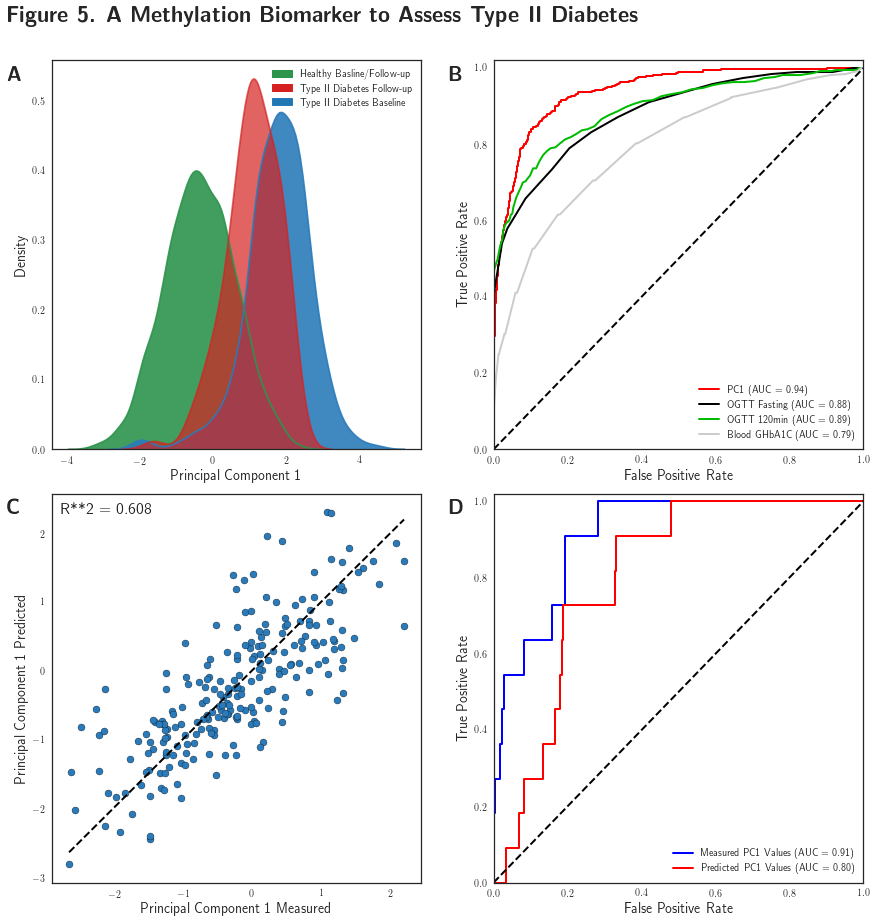

In [60]:
fig, axes = plt.subplots(sharex=False, figsize=(12,12))

lw = 2

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1)


sns.kdeplot(healthy['PC1'], shade=True,shade_lowest=False, alpha=.9, ax=ax1, color=sns.color_palette("Greens")[-2])
sns.kdeplot(type2_baseline['PC1'], shade=True,shade_lowest=False, alpha=.9,ax=ax1, color=sns.color_palette("Blues")[-2])
sns.kdeplot(type2_followup['PC1'], shade=True,shade_lowest=False, alpha=.7,ax=ax1, color=sns.color_palette("Reds")[-2])
L = ax1.legend(handles=[green_patch, red_patch, blue_patch])
L.get_texts()[0].set_text('Healthy Basline/Follow-up')
L.get_texts()[1].set_text('Type II Diabetes Follow-up')
L.get_texts()[2].set_text('Type II Diabetes Baseline')
ax1.set_xlabel('Principal Component 1', fontsize=14) 
ax1.set_ylabel('Density', fontsize=14)
fig.tight_layout()

plt.sca(ax2)        
ax2.plot(fpr_followup_traits_pc1, tpr_followup_traits_pc1, color='red',
         lw=lw, label='PC1 (AUC = %0.2f)' % folowup_auc)
for count, feature in enumerate(roc_comparison):
    ax2.plot(feature[0], feature[1], color=trait_color_spectrum[count],
             lw=lw, label='%s (AUC = %0.2f)' % (common_diagnostic_metrics[list(common_diagnostic_metrics.keys())[count]] , feature[2])) 
ax2.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
ax2.set_ylabel('True Positive Rate', fontsize=14)
ax2.set_xlabel('False Positive Rate', fontsize=14)
ax2.legend(loc="lower right")


ax3.scatter(pc1_values, predict, edgecolors=(0, 0, 0), color=sns.color_palette("Blues")[-2])
plot_fit = r2(pc1_values, predict)
plot_fit = 'R**2 = ' + str(round(plot_fit,4))
ax3.text(0.025, .95, plot_fit,transform=ax3.transAxes, fontsize=16)
ax3.plot([np.asarray(pc1_values).min(), np.asarray(pc1_values).max()], [np.asarray(pc1_values).min(), np.asarray(pc1_values).max()], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
ax3.set_xlabel('Principal Component 1 Measured', fontsize=14)
ax3.set_ylabel('Principal Component 1 Predicted', fontsize=14)


plt.sca(ax4)

ax4.plot(fpr_actual, tpr_actual, color='blue',
         lw=lw, label='%s (AUC = %0.2f)' % ('Measured PC1 Values', actual_auc ))
ax4.plot(fpr_predicted, tpr_predicted, color='red',
         lw=lw, label='%s (AUC = %0.2f)' % ('Predicted PC1 Values', predicted_auc ))
ax4.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
ax4.set_xlabel('False Positive Rate', fontsize=14)
ax4.set_ylabel('True Positive Rate', fontsize=14)
ax4.legend(loc="lower right")


label_position_y = .95
label_position_x = -0.12
label_font_size = 20

ax1.text(-0.12, 1.1, '\\textbf{Figure 5. A Methylation Biomarker to Assess Type II Diabetes}',transform=ax1.transAxes, fontsize=label_font_size+2)

#figure_caption = ('\\begin{minipage}{0.16\linewidth}\\textbf{Figure 5. Methylation Biomarker to Assess Type II Diabetes.}' + caption_text + '\\end{minipage}')
#ax3.text(0, -.35, figure_caption, transform=ax3.transAxes, fontsize=12)



ax1.text(label_position_x, label_position_y, '\\textbf{A}', transform=ax1.transAxes, weight='bold', fontsize=label_font_size)
ax2.text(label_position_x, label_position_y, '\\textbf{B}', transform=ax2.transAxes, weight='bold', fontsize=label_font_size)
ax3.text(label_position_x, label_position_y, '\\textbf{C}', transform=ax3.transAxes, weight='bold', fontsize=label_font_size)
ax3.text(label_position_x, label_position_y, '\\textbf{D}', transform=ax4.transAxes, weight='bold', fontsize=label_font_size)


plt.tight_layout(pad=0.4, w_pad=3, h_pad=1.0)

#plt.savefig('Figure5.png', bbox_inches='tight', dpi=600)
plt.show()